# Notebook 03: First-Stage Verification

**Objective:**
1. **Verify Parallel Trends:** Confirm that Treated and Control stocks had similar coverage trends *before* the shock.
2. **Confirm Shock Magnitude:** Visually demonstrate the sharp drop in coverage at $t=0$.
3. **Test Instrument Strength:** Calculate the First-Stage F-Statistic.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS

Load and prepare regression

In [10]:
file_path = 'data/instrument_panel.csv'
df_panel = pd.read_csv(file_path)

In [11]:
df_panel['Unique_ID'] = df_panel['CUSIP'].astype(str) + "-" + df_panel['Event_ID'].astype(str)
df_panel = df_panel.set_index(['Unique_ID', 'Event_Month'])

Run event study regression

We regress coverage on `Treated x Month` dummies

We omit $t = -1$ as the reference period (coefficient = 0).

In [12]:
months = list(range(-6, 7))
months.remove(-1)
formula_parts = []

for m in months:
    # interaction: Treated * (Month == m)
    # we create the variable name
    label = f"T_minus_{abs(m)}" if m < 0 else f"T_plus_{m}"

    # create the dummy column in the dataframe
    df_panel[label] = df_panel['Treated'] * (df_panel.index.get_level_values('Event_Month') == m).astype(int)
    formula_parts.append(label)

In [13]:
# define formula and fit model
# Coverage ~ Interactions + Entity Fixed Effects + Time Fixed Effects
formula = 'Coverage ~ ' + ' + '.join(formula_parts) + ' + EntityEffects + TimeEffects'
mod = PanelOLS.from_formula(formula, data=df_panel)
res = mod.fit(cov_type='clustered', clusters=df_panel['Event_ID'])
print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               Coverage   R-squared:                        0.0211
Estimator:                   PanelOLS   R-squared (Between):             -0.0420
No. Observations:               70330   R-squared (Within):               0.0482
Date:                Sun, Dec 07 2025   R-squared (Overall):             -0.0404
Time:                        17:46:29   Log-likelihood                -1.103e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      116.53
Entities:                        5410   P-value                           0.0000
Avg Obs:                       13.000   Distribution:                F(12,64896)
Min Obs:                       13.000                                           
Max Obs:                       13.000   F-statistic (robust):             3294.8
                            

Plot the results

In [14]:
coefs = []
err_lower = []
err_upper = []
plot_months = range(-6, 7)
conf_int = res.conf_int()

for m in plot_months:
    if m == -1:
        # Reference point
        coefs.append(0)
        err_lower.append(0)
        err_upper.append(0)
    else:
        label = f"T_minus_{abs(m)}" if m < 0 else f"T_plus_{m}"

        beta = res.params[label]
        lower = conf_int.loc[label, 'lower']
        upper = conf_int.loc[label, 'upper']

        coefs.append(beta)
        err_lower.append(beta - lower)
        err_upper.append(upper - beta)

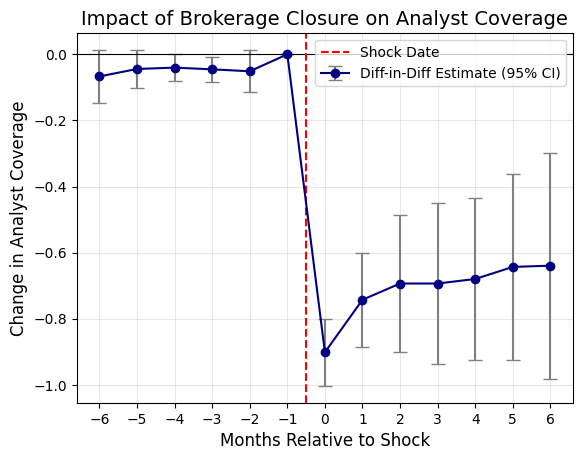

In [15]:
plt.errorbar(plot_months, coefs, yerr=[err_lower, err_upper],
             fmt='o-', color='navy', ecolor='gray', capsize=5,
             label='Diff-in-Diff Estimate (95% CI)')

plt.axhline(0, color='black', linestyle='-', linewidth=0.8)
plt.axvline(-0.5, color='red', linestyle='--', label='Shock Date')

plt.title('Impact of Brokerage Closure on Analyst Coverage', fontsize=14)
plt.xlabel('Months Relative to Shock', fontsize=12)
plt.ylabel('Change in Analyst Coverage', fontsize=12)
plt.xticks(plot_months)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('images/event_study_plot.png', dpi=300)
plt.show()

Calculate instrument strength

In [16]:
# run simple difference-in-differences (pre v. post)
# formula: coverage ~ treated * post + fixed effects
formula_simple = 'Coverage ~ Treated_Post + EntityEffects + TimeEffects'

mod_simple = PanelOLS.from_formula(formula_simple, data=df_panel)
res_simple = mod_simple.fit(cov_type='clustered', clusters=df_panel['Event_ID'])

beta = res_simple.params['Treated_Post']
t_stat = res_simple.tstats['Treated_Post']
f_stat_robust = t_stat ** 2

print(f"DiD Coefficient: {beta:.4f}")
print(f"T-Statistic: {t_stat:.4f}")
print(f"Robust F-Statistic: {f_stat_robust:.4f}")

DiD Coefficient: -0.6720
T-Statistic: -6.3164
Robust F-Statistic: 39.8972


In [18]:
print(res_simple.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               Coverage   R-squared:                        0.0204
Estimator:                   PanelOLS   R-squared (Between):             -0.0376
No. Observations:               70330   R-squared (Within):               0.0507
Date:                Sun, Dec 07 2025   R-squared (Overall):             -0.0360
Time:                        17:46:42   Log-likelihood                -1.103e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1350.3
Entities:                        5410   P-value                           0.0000
Avg Obs:                       13.000   Distribution:                 F(1,64907)
Min Obs:                       13.000                                           
Max Obs:                       13.000   F-statistic (robust):             39.897
                            